In [ ]:
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
! wget https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX12/midv500p.zip
! unzip -qn midv500p.zip
! rm midv500p.zip

--2023-06-05 12:26:14--  https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX12/midv500p.zip
Resolving edunet.kea.su (edunet.kea.su)... 89.175.15.242
Connecting to edunet.kea.su (edunet.kea.su)|89.175.15.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9183651 (8.8M) [application/zip]
Saving to: ‘midv500p.zip’

midv500p.zip        100%[===================>]   8.76M  4.19MB/s    in 2.1s    

2023-06-05 12:26:17 (4.19 MB/s) - ‘midv500p.zip’ saved [9183651/9183651]



In [ ]:
class MaskDataset(Dataset):
    def __init__(self, train_part=True, transform=None, path="midv500p"):
        self.transform = transform
        path += "/train" if train_part else "/val"
        files = glob.glob(path + "/image/*")
        self.loaded_images = []
        self.loaded_masks = []

        for filename in files:
            self.loaded_images.append(Image.open(filename))
            mask_fn = filename.replace("image", "mask").replace("jpg", "png")
            self.loaded_masks.append(Image.open(mask_fn))

    def __getitem__(self, i):
        img = self.loaded_images[i]
        mask = self.loaded_masks[i]

        # Not accept random transform, for these use Albumentation library
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

    def __len__(self):
        return len(self.loaded_images)

In [ ]:
transform_train = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((224, 224))]
)  # Augmentations
transform_val = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((224, 224))]
)

trainset = MaskDataset(train_part=True, transform=transform_train)
valset = MaskDataset(train_part=False, transform=transform_val)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=4, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


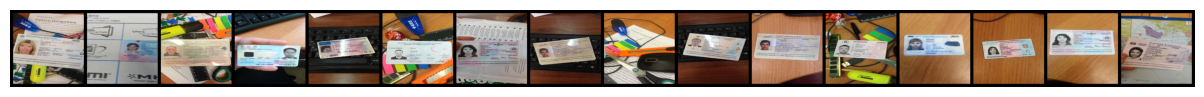

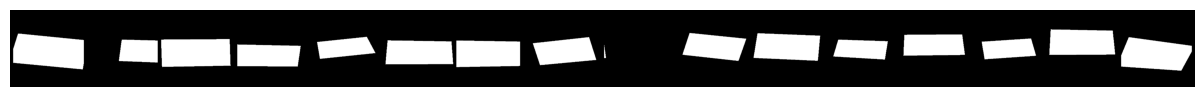

In [ ]:
def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))


images, masks = next(iter(train_loader))

show(images)
show(masks)

In [ ]:
class MiniUnet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # Without learning params
        self.down = nn.MaxPool2d((2, 2), return_indices=True)
        self.up = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # With learning params
        self.block1 = self.build_block(3, 32)
        self.block2 = self.build_block(32, 64)

        self.bottle_neck = nn.Sequential(
            self.build_block(64, 128), self.build_block(128, 64)
        )

        self.block4 = self.build_block(128, 32)
        self.block5 = self.build_block(64, 32)
        self.conv2d = nn.Sequential(
            nn.Conv2d(32, num_classes, kernel_size=1), nn.Sigmoid()
        )

    def build_block(self, ch_in, ch_out):
        return nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        # Encoder
        out1 = self.block1(x)  # C 3 -> 32 , HW 224x224
        out_pool1, indeces1 = self.down(out1)  # C 32 , HW 224->112
        out2 = self.block2(out_pool1)  # 32 -> 64
        out_pool2, indeces2 = self.down(out2)  # HW 112->56

        out3 = self.bottle_neck(out_pool2)  # 64->128->64

        # Decoder
        out_up1 = self.up(out3, indeces2)  # CH 64 HW 56 -> 112
        skip2 = torch.cat((out_up1, out2), dim=1)  # CH 64 + 64 = 128 ->  64
        out4 = self.block4(skip2)  # CH 128 -> 32 HW 112
        skip1 = self.up(out4, indeces1)  # CH 32 + 32 = 64
        out5 = torch.cat((skip1, out1), dim=1)  # 64->  32
        out5 = self.block5(out5)  # CH 32,  HW 112 -> 224

        out = self.conv2d(out5)  # CH32 -> 1
        return out

In [ ]:
model = MiniUnet()
summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         Dropout2d-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
         MaxPool2d-6  [[-1, 32, 112, 112], [-1, 32, 112, 112]]               0
            Conv2d-7         [-1, 64, 112, 112]          18,496
              ReLU-8         [-1, 64, 112, 112]               0
         Dropout2d-9         [-1, 64, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]          36,928
             ReLU-11         [-1, 64, 112, 112]               0
        MaxPool2d-12  [[-1, 64, 56, 56], [-1, 64, 56, 56]]               0
           Conv2d-13          [-1, 128, 56, 56]          73,856
             

Обучите модель:

In [ ]:
def train(model, criterion, optimizer, epoch=None, masks_in_progress=[]):
    ep_loss = 0
    model.train()
    for img_batch, masks_batch in train_loader:
        optimizer.zero_grad()
        output = model(img_batch.to(device))
        loss = criterion(output, masks_batch.to(device))
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()

    val_loss = 0
    for i, batch in enumerate(val_loader):
        with torch.no_grad():
            img_batch, masks_batch = batch
            output = model(img_batch.to(device))
            loss = criterion(output, masks_batch.to(device))
            val_loss += loss.item()
            if i == 0:
                masks_in_progress.append(output[1].cpu())

    print(
        "Epoch {} Train loss {:.2f} Val loss {:.2f}".format(
            epoch, ep_loss / len(train_loader), val_loss / len(val_loader)
        )
    )

In [ ]:
model = MiniUnet()
criterion = nn.BCELoss() 
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
masks_in_progress = []
for epoch in range(15):
    train(model, criterion, optimizer, epoch, masks_in_progress)

Epoch 0 Train loss 0.68 Val loss 0.67
Epoch 1 Train loss 0.66 Val loss 0.64
Epoch 2 Train loss 0.62 Val loss 0.57
Epoch 3 Train loss 0.50 Val loss 0.39
Epoch 4 Train loss 0.37 Val loss 0.35
Epoch 5 Train loss 0.34 Val loss 0.34
Epoch 6 Train loss 0.33 Val loss 0.34
Epoch 7 Train loss 0.32 Val loss 0.32
Epoch 8 Train loss 0.31 Val loss 0.31
Epoch 9 Train loss 0.30 Val loss 0.30
Epoch 10 Train loss 0.30 Val loss 0.31
Epoch 11 Train loss 0.30 Val loss 0.30
Epoch 12 Train loss 0.29 Val loss 0.30
Epoch 13 Train loss 0.29 Val loss 0.29
Epoch 14 Train loss 0.29 Val loss 0.31


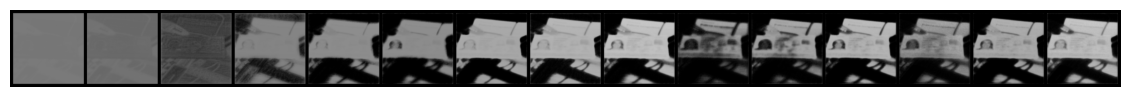

In [ ]:
show(masks_in_progress)

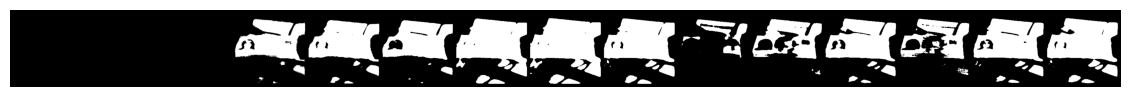

In [ ]:
mt = torch.stack(masks_in_progress)
binary_mask = mt > 0.5
show(binary_mask.float())

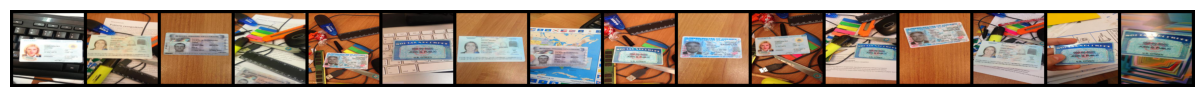

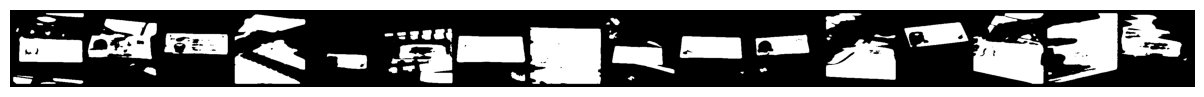

In [ ]:
def show_valset_pred(model, cols=16):
    images, pred_masks = [], []
    for batch in valset:
        with torch.no_grad():
            img, mask = batch
            images.append(img.unsqueeze(0))
            output = model(img.unsqueeze(0).to(device))
            pred_masks.append(output.cpu())
    show(torch.stack(images).squeeze()[:cols, ...])
    binary_mask = torch.stack(pred_masks) > 0.5
    show(binary_mask.squeeze(1).float()[:cols, ...])


show_valset_pred(model)

In [ ]:
def measure_metric_on_valset(model):
    pred_masks, gt_masks = [], []
    for batch in valset:
        with torch.no_grad():
            img, mask = batch
            gt_masks.append(mask.unsqueeze(0))
            output = model(img.unsqueeze(0).to(device))
            pred_masks.append(output.cpu())

    outputs = (torch.stack(pred_masks).squeeze() > 0.5).int()
    labels = torch.stack(gt_masks).squeeze().int()
    SMOOTH = 1e-6

    # Will be zero if Truth=0 or Prediction=0
    intersection = (outputs & labels).float().sum((1, 2))
    # Will be zzero if both are 0
    union = (outputs | labels).float().sum((1, 2))

    # We smooth our devision to avoid 0/0
    iou = (intersection + SMOOTH) / (union + SMOOTH)

    # for average IOU across the images
    return iou.mean().unsqueeze(0).numpy()[0]

In [ ]:
measure_metric_on_valset(model)

0.70703995

In [ ]:
class BinaryDiceLoss(nn.Module):
    """Soft Dice loss of binary class
    Args:
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
       Returns:
        Loss tensor

    """

    def __init__(self, p=2, epsilon=1e-6):
        super().__init__()
        self.p = p  # pow degree
        self.epsilon = epsilon

    def forward(self, predict, target):
        predict = predict.flatten(1)
        target = target.flatten(1)

        # https://pytorch.org/docs/stable/generated/torch.mul.html
        num = torch.sum(torch.mul(predict, target), dim=1) + self.epsilon
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.epsilon
        loss = 1 - 2 * num / den

        return loss.mean()  # over batch

In [ ]:
model = MiniUnet()
model.train()
model.to(device)

criterion = BinaryDiceLoss() 
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
masks_in_progress = []
for epoch in range(10):
    train(model, criterion, optimizer, epoch, masks_in_progress)

Epoch 0 Train loss 0.50 Val loss 0.50
Epoch 1 Train loss 0.49 Val loss 0.49
Epoch 2 Train loss 0.46 Val loss 0.43
Epoch 3 Train loss 0.37 Val loss 0.31
Epoch 4 Train loss 0.27 Val loss 0.25
Epoch 5 Train loss 0.22 Val loss 0.21
Epoch 6 Train loss 0.20 Val loss 0.22
Epoch 7 Train loss 0.20 Val loss 0.19
Epoch 8 Train loss 0.19 Val loss 0.19
Epoch 9 Train loss 0.18 Val loss 0.18


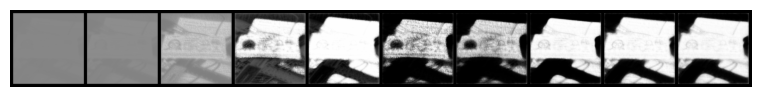

In [ ]:
show(masks_in_progress)

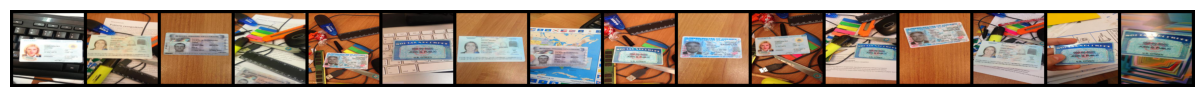

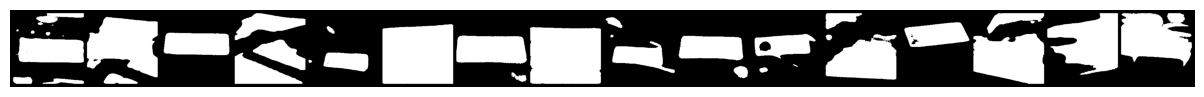

In [ ]:
show_valset_pred(model)

In [ ]:
measure_metric_on_valset(model)

0.69693154